In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import re
import nltk
import spacy
import string
pd.options.mode.chained_assignment = None

In [ ]:
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
plt.style.use('fivethirtyeight')
print(tf.__version__)


2.7.0


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score, matthews_corrcoef,precision_score,average_precision_score,recall_score,f1_score,roc_auc_score
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVC 

In [ ]:
glove_filename='glove.6B.100d.txt'
glove_path='/content/drive/MyDrive/Colab Notebooks/glove.6B.100d.txt'

In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec

#glove_input_file = glove_filename
word2vec_output_file = glove_filename+'.word2vec'
glove2word2vec(glove_path, word2vec_output_file)

(400000, 100)

In [ ]:
from gensim.models import KeyedVectors
# load the Stanford GloVe model
word2vec_output_file = glove_filename+'.word2vec'
model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

In [ ]:
class Word2VecVectorizer:
  def __init__(self, model):
    print("Loading in word vectors...")
    self.word_vectors = model
    print("Finished loading in word vectors")

  def fit(self, data):
    pass

  def transform(self, data):
    # determine the dimensionality of vectors
    v = self.word_vectors.get_vector('king')
    self.D = v.shape[0]

    X = np.zeros((len(data), self.D))
    n = 0
    emptycount = 0
    for sentence in data:
      tokens = sentence.split()
      vecs = []
      m = 0
      for word in tokens:
        try:
          # throws KeyError if word not found
          vec = self.word_vectors.get_vector(word)
          vecs.append(vec)
          m += 1
        except KeyError:
          pass
      if len(vecs) > 0:
        vecs = np.array(vecs)
        X[n] = vecs.mean(axis=0)
      else:
        emptycount += 1
      n += 1
    print("Numer of samples with no words found: %s / %s" % (emptycount, len(data)))
    return X


  def fit_transform(self, data):
    self.fit(data)
    return self.transform(data)

In [ ]:
df1 = pd.read_csv("/content/hateval2019_en_train.csv")
df2= pd.read_csv("/content/hateval2019_en_test.csv")
full_df= df1.append(df2,ignore_index=True)
# df = full_df[["text"]]
full_df["text"] = full_df["text"].astype(str)
full_df.head()

,id,text,HS,TR,AG
0,201,"Hurray, saving us $$$ in so many ways @potus @...",1,0,0
1,202,Why would young fighting age men be the vast m...,1,0,0
2,203,@KamalaHarris Illegals Dump their Kids at the ...,1,0,0
3,204,NY Times: 'Nearly All White' States Pose 'an A...,0,0,0
4,205,Orban in Brussels: European leaders are ignori...,0,0,0


In [ ]:
df= full_df.sample(frac=1.0)
df= df.reset_index(drop=True)

In [ ]:
df.drop(['id'],axis=1,inplace=True)
df.shape

(12000, 4)

REMOVE USERNAME

In [ ]:
import re

def remove_usernames_links(tweet):
    tweet = re.sub(r'@[^\s]+','',tweet)
    tweet = re.sub(r'http[^\s]+','',tweet)
    return tweet

df['tweet'] = df["text"].apply(remove_usernames_links)
df.head()

,text,HS,TR,AG,tweet
0,When you know you're a piece of shit and own i...,0,0,0,When you know you're a piece of shit and own i...
1,@MomsRising @Re4mImmigration @DHSgov American ...,1,0,0,American Kids Killed by Illegals are Perman...
2,Me when people take a post too seriously and I...,0,0,0,Me when people take a post too seriously and I...
3,"Immigration ""loophole"" that Trump bemoaned ret...",0,0,0,"Immigration ""loophole"" that Trump bemoaned ret..."
4,My whole life is one big sexual innuendo,0,0,0,My whole life is one big sexual innuendo


LOWER CASING

In [ ]:
df["text_lower"] = df["tweet"].str.lower()
df.head()

,text,HS,TR,AG,tweet,text_lower
0,When you know you're a piece of shit and own i...,0,0,0,When you know you're a piece of shit and own i...,when you know you're a piece of shit and own i...
1,@MomsRising @Re4mImmigration @DHSgov American ...,1,0,0,American Kids Killed by Illegals are Perman...,american kids killed by illegals are perman...
2,Me when people take a post too seriously and I...,0,0,0,Me when people take a post too seriously and I...,me when people take a post too seriously and i...
3,"Immigration ""loophole"" that Trump bemoaned ret...",0,0,0,"Immigration ""loophole"" that Trump bemoaned ret...","immigration ""loophole"" that trump bemoaned ret..."
4,My whole life is one big sexual innuendo,0,0,0,My whole life is one big sexual innuendo,my whole life is one big sexual innuendo


REMOVE PUNCTUATIONS

In [ ]:
# drop the new column created in last cell
#df.drop(["text_lower"], axis=1, inplace=True)

PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

df["text_wo_punct"] = df['text_lower'].apply(lambda text: remove_punctuation(text))
df.head()

,text,HS,TR,AG,tweet,text_lower,text_wo_punct
0,When you know you're a piece of shit and own i...,0,0,0,When you know you're a piece of shit and own i...,when you know you're a piece of shit and own i...,when you know youre a piece of shit and own it...
1,@MomsRising @Re4mImmigration @DHSgov American ...,1,0,0,American Kids Killed by Illegals are Perman...,american kids killed by illegals are perman...,american kids killed by illegals are perman...
2,Me when people take a post too seriously and I...,0,0,0,Me when people take a post too seriously and I...,me when people take a post too seriously and i...,me when people take a post too seriously and i...
3,"Immigration ""loophole"" that Trump bemoaned ret...",0,0,0,"Immigration ""loophole"" that Trump bemoaned ret...","immigration ""loophole"" that trump bemoaned ret...",immigration loophole that trump bemoaned retur...
4,My whole life is one big sexual innuendo,0,0,0,My whole life is one big sexual innuendo,my whole life is one big sexual innuendo,my whole life is one big sexual innuendo


STOPWORDS

In [ ]:
!pip install nltk

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))


"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [ ]:
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df["text_wo_stop"] = df["text_wo_punct"].apply(lambda text: remove_stopwords(text))
df.head()

,text,HS,TR,AG,tweet,text_lower,text_wo_punct,text_wo_stop
0,When you know you're a piece of shit and own i...,0,0,0,When you know you're a piece of shit and own i...,when you know you're a piece of shit and own i...,when you know youre a piece of shit and own it...,know youre piece shit like boss
1,@MomsRising @Re4mImmigration @DHSgov American ...,1,0,0,American Kids Killed by Illegals are Perman...,american kids killed by illegals are perman...,american kids killed by illegals are perman...,american kids killed illegals permanently sepa...
2,Me when people take a post too seriously and I...,0,0,0,Me when people take a post too seriously and I...,me when people take a post too seriously and i...,me when people take a post too seriously and i...,people take post seriously im reading butt hur...
3,"Immigration ""loophole"" that Trump bemoaned ret...",0,0,0,"Immigration ""loophole"" that Trump bemoaned ret...","immigration ""loophole"" that trump bemoaned ret...",immigration loophole that trump bemoaned retur...,immigration loophole trump bemoaned returns ze...
4,My whole life is one big sexual innuendo,0,0,0,My whole life is one big sexual innuendo,my whole life is one big sexual innuendo,my whole life is one big sexual innuendo,whole life one big sexual innuendo


REMOVE URLS

In [ ]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

In [ ]:
df["text_wo_urlno"] = df["text_wo_stop"].apply(lambda text: remove_urls(text))
df.head()

,text,HS,TR,AG,tweet,text_lower,text_wo_punct,text_wo_stop,text_wo_urlno
0,When you know you're a piece of shit and own i...,0,0,0,When you know you're a piece of shit and own i...,when you know you're a piece of shit and own i...,when you know youre a piece of shit and own it...,know youre piece shit like boss,know youre piece shit like boss
1,@MomsRising @Re4mImmigration @DHSgov American ...,1,0,0,American Kids Killed by Illegals are Perman...,american kids killed by illegals are perman...,american kids killed by illegals are perman...,american kids killed illegals permanently sepa...,american kids killed illegals permanently sepa...
2,Me when people take a post too seriously and I...,0,0,0,Me when people take a post too seriously and I...,me when people take a post too seriously and i...,me when people take a post too seriously and i...,people take post seriously im reading butt hur...,people take post seriously im reading butt hur...
3,"Immigration ""loophole"" that Trump bemoaned ret...",0,0,0,"Immigration ""loophole"" that Trump bemoaned ret...","immigration ""loophole"" that trump bemoaned ret...",immigration loophole that trump bemoaned retur...,immigration loophole trump bemoaned returns ze...,immigration loophole trump bemoaned returns ze...
4,My whole life is one big sexual innuendo,0,0,0,My whole life is one big sexual innuendo,my whole life is one big sexual innuendo,my whole life is one big sexual innuendo,whole life one big sexual innuendo,whole life one big sexual innuendo


REMOVE HTML TAGS

In [ ]:
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

df["text_wo_htmlno"] = df["text_wo_urlno"].apply(lambda text: remove_html(text))
df.head()


,text,HS,TR,AG,tweet,text_lower,text_wo_punct,text_wo_stop,text_wo_urlno,text_wo_htmlno
0,When you know you're a piece of shit and own i...,0,0,0,When you know you're a piece of shit and own i...,when you know you're a piece of shit and own i...,when you know youre a piece of shit and own it...,know youre piece shit like boss,know youre piece shit like boss,know youre piece shit like boss
1,@MomsRising @Re4mImmigration @DHSgov American ...,1,0,0,American Kids Killed by Illegals are Perman...,american kids killed by illegals are perman...,american kids killed by illegals are perman...,american kids killed illegals permanently sepa...,american kids killed illegals permanently sepa...,american kids killed illegals permanently sepa...
2,Me when people take a post too seriously and I...,0,0,0,Me when people take a post too seriously and I...,me when people take a post too seriously and i...,me when people take a post too seriously and i...,people take post seriously im reading butt hur...,people take post seriously im reading butt hur...,people take post seriously im reading butt hur...
3,"Immigration ""loophole"" that Trump bemoaned ret...",0,0,0,"Immigration ""loophole"" that Trump bemoaned ret...","immigration ""loophole"" that trump bemoaned ret...",immigration loophole that trump bemoaned retur...,immigration loophole trump bemoaned returns ze...,immigration loophole trump bemoaned returns ze...,immigration loophole trump bemoaned returns ze...
4,My whole life is one big sexual innuendo,0,0,0,My whole life is one big sexual innuendo,my whole life is one big sexual innuendo,my whole life is one big sexual innuendo,whole life one big sexual innuendo,whole life one big sexual innuendo,whole life one big sexual innuendo


REMOVE DIGITS

In [ ]:
#df['text_wo_digitno'] = df['text_wo_urlno'].apply(lambda x: re.sub('W*dw*','',x))
#df.head()

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

LEMMATIZATION

In [ ]:
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

df["text_lemmatized"] = df["text_wo_htmlno"].apply(lambda text: lemmatize_words(text))
df.head()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


,text,HS,TR,AG,tweet,text_lower,text_wo_punct,text_wo_stop,text_wo_urlno,text_wo_htmlno,text_lemmatized
0,When you know you're a piece of shit and own i...,0,0,0,When you know you're a piece of shit and own i...,when you know you're a piece of shit and own i...,when you know youre a piece of shit and own it...,know youre piece shit like boss,know youre piece shit like boss,know youre piece shit like boss,know youre piece shit like bos
1,@MomsRising @Re4mImmigration @DHSgov American ...,1,0,0,American Kids Killed by Illegals are Perman...,american kids killed by illegals are perman...,american kids killed by illegals are perman...,american kids killed illegals permanently sepa...,american kids killed illegals permanently sepa...,american kids killed illegals permanently sepa...,american kid kill illegals permanently separat...
2,Me when people take a post too seriously and I...,0,0,0,Me when people take a post too seriously and I...,me when people take a post too seriously and i...,me when people take a post too seriously and i...,people take post seriously im reading butt hur...,people take post seriously im reading butt hur...,people take post seriously im reading butt hur...,people take post seriously im read butt hurt c...
3,"Immigration ""loophole"" that Trump bemoaned ret...",0,0,0,"Immigration ""loophole"" that Trump bemoaned ret...","immigration ""loophole"" that trump bemoaned ret...",immigration loophole that trump bemoaned retur...,immigration loophole trump bemoaned returns ze...,immigration loophole trump bemoaned returns ze...,immigration loophole trump bemoaned returns ze...,immigration loophole trump bemoan return zero ...
4,My whole life is one big sexual innuendo,0,0,0,My whole life is one big sexual innuendo,my whole life is one big sexual innuendo,my whole life is one big sexual innuendo,whole life one big sexual innuendo,whole life one big sexual innuendo,whole life one big sexual innuendo,whole life one big sexual innuendo


In [ ]:
df['text_lemmatized'].to_list

<bound method IndexOpsMixin.tolist of 0                           know youre piece shit like bos
1        american kid kill illegals permanently separat...
2        people take post seriously im read butt hurt c...
3        immigration loophole trump bemoan return zero ...
4                       whole life one big sexual innuendo
                               ...                        
11995    yet trah come america free load kindness human...
11996          everyone call elly slut whore hell evidence
11997    business move california democrat put criminal...
11998    savage indians live reputationdeportthemall bu...
11999    bitch come love talk shit phone thats let dad ...
Name: text_lemmatized, Length: 12000, dtype: object>

WORD CLOUD 




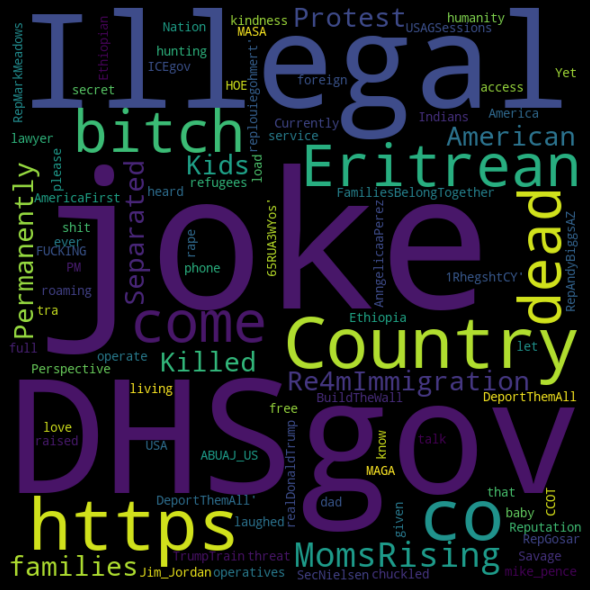

In [ ]:
comments = df['text'].loc[df['HS']==1].values
wordcloud = WordCloud(
    width = 640,
    height = 640,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(comments))
fig = plt.figure(
    figsize = (12, 8),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


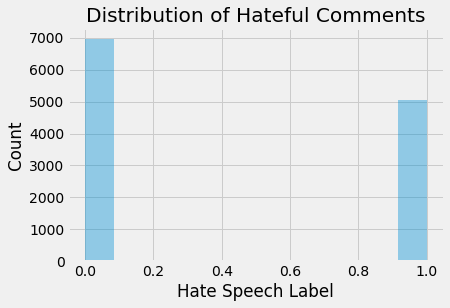

In [ ]:
# Plot frequency of hateful comments
fig = sns.distplot(df['HS'], kde=False)
plt.xlabel("Hate Speech Label")
plt.ylabel("Count")
plt.title("Distribution of Hateful Comments")
plt.show(fig)

In [ ]:
df['HS'].value_counts()


0    6957
1    5043
Name: HS, dtype: int64

TOKENIZATION

In [ ]:
nltk.download('punkt')

nltk_token = df["text_lemmatized"].apply(lambda text:  nltk.word_tokenize(text))
#df.head()
print(nltk_token)
#nltk_tokens = nltk.sent_tokenize(df['text_lemmatized'])
#print (nltk_tokens)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
0                    [know, youre, piece, shit, like, bos]
1        [american, kid, kill, illegals, permanently, s...
2        [people, take, post, seriously, im, read, butt...
3        [immigration, loophole, trump, bemoan, return,...
4                [whole, life, one, big, sexual, innuendo]
                               ...                        
11995    [yet, trah, come, america, free, load, kindnes...
11996    [everyone, call, elly, slut, whore, hell, evid...
11997    [business, move, california, democrat, put, cr...
11998    [savage, indians, live, reputationdeportthemal...
11999    [bitch, come, love, talk, shit, phone, thats, ...
Name: text_lemmatized, Length: 12000, dtype: object


In [ ]:
df[["tokenized_text"]] = nltk_token
df.head()

,text,HS,TR,AG,tweet,text_lower,text_wo_punct,text_wo_stop,text_wo_urlno,text_wo_htmlno,text_lemmatized,tokenized_text
0,When you know you're a piece of shit and own i...,0,0,0,When you know you're a piece of shit and own i...,when you know you're a piece of shit and own i...,when you know youre a piece of shit and own it...,know youre piece shit like boss,know youre piece shit like boss,know youre piece shit like boss,know youre piece shit like bos,"[know, youre, piece, shit, like, bos]"
1,@MomsRising @Re4mImmigration @DHSgov American ...,1,0,0,American Kids Killed by Illegals are Perman...,american kids killed by illegals are perman...,american kids killed by illegals are perman...,american kids killed illegals permanently sepa...,american kids killed illegals permanently sepa...,american kids killed illegals permanently sepa...,american kid kill illegals permanently separat...,"[american, kid, kill, illegals, permanently, s..."
2,Me when people take a post too seriously and I...,0,0,0,Me when people take a post too seriously and I...,me when people take a post too seriously and i...,me when people take a post too seriously and i...,people take post seriously im reading butt hur...,people take post seriously im reading butt hur...,people take post seriously im reading butt hur...,people take post seriously im read butt hurt c...,"[people, take, post, seriously, im, read, butt..."
3,"Immigration ""loophole"" that Trump bemoaned ret...",0,0,0,"Immigration ""loophole"" that Trump bemoaned ret...","immigration ""loophole"" that trump bemoaned ret...",immigration loophole that trump bemoaned retur...,immigration loophole trump bemoaned returns ze...,immigration loophole trump bemoaned returns ze...,immigration loophole trump bemoaned returns ze...,immigration loophole trump bemoan return zero ...,"[immigration, loophole, trump, bemoan, return,..."
4,My whole life is one big sexual innuendo,0,0,0,My whole life is one big sexual innuendo,my whole life is one big sexual innuendo,my whole life is one big sexual innuendo,whole life one big sexual innuendo,whole life one big sexual innuendo,whole life one big sexual innuendo,whole life one big sexual innuendo,"[whole, life, one, big, sexual, innuendo]"


GloVE

In [ ]:
# vectorizer = Word2VecVectorizer(model)
# # Get the sentence embeddings for the train dataset
# Xtrain = vectorizer.fit_transform(X_train)
# Ytrain = train_labels
# # Get the sentence embeddings for the test dataset
# Xtest = vectorizer.transform(X_test)
# Ytest = test_labels

We are converting words to glove embeddings and then finding sentence embeddings.The ith value in the sentence embedding will be the mean of the ith values in the word embedding of all the words in the sentence.
The GloVe embeddings are converted to word2vec format

In [ ]:
df_p= df['text_lemmatized']
df_n= df['HS']

SVM

In [ ]:
def SVM_model(df_p,df_n):
  # 10-fold cross validation for hyperparamter tuning
  parameters = {'kernel':['rbf'],'C': [0.1, 1, 10, 100], 'gamma': [0.001, 0.01,1, 10]}
  class_split=[]
  result=[]
  best_score=[]
  validation=[]
  test=[]
  pivots=[]
  for i in range(1):
    print(i)

    # split
    x_train, x_test, y_train, y_test = train_test_split(df_p,df_n, test_size=0.20)

    vectorizer = Word2VecVectorizer(model)
    # Get the sentence embeddings for the train dataset
    X_train = vectorizer.fit_transform(x_train)
    # Get the sentence embeddings for the test dataset
    X_test = vectorizer.transform(x_test)

    #number of positives and negatives
    class_split.append({'split_no': i,'train_p':sum(y_train==1),'train_n':sum(y_train==0),'test_p':sum(y_test==1),'test_n':sum(y_test==0)})
    # print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)
    # grid search
    grid = GridSearchCV(SVC(probability=True), parameters,scoring="accuracy" ,cv=5) #uses accuracy for scoring and 10 fold cross validation
    grid.fit(X_train, y_train)
    #best score and parameters
    best_score.append({"Split":i,"Acc":grid.best_score_,"C":grid.best_params_['C'],'gamma':grid.best_params_['gamma']})
    # results of each split
    res = pd.DataFrame(grid.cv_results_)
    result.append(res)
    pvt = pd.pivot_table(res,values='mean_test_score', index='param_C', columns='param_gamma')
    pivots.append(pvt)
    plt.figure(i)
    sns.heatmap(pvt,cmap='magma',annot=True)

    #storing training metrics
    y_train_pred= grid.predict(X_train)
    # train_probs = grid.predict_proba(X_train)
    # train_probs= train_probs[:,-1]

    TN,FP,FN,TP = confusion_matrix(y_train,y_train_pred, labels=[0, 1]).ravel()
    #Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    # MCC=matthews_corrcoef(y_train,y_train_pred)
    #F1 score
    f1= f1_score(y_train,y_train_pred)
    #precision
    train_pr= precision_score(y_train,y_train_pred)
    #recall
    train_re = recall_score(y_train,y_train_pred)
    #PR AUC
    # pr_auc= average_precision_score(y_train,train_probs)
    #ROC AUC
    # roc_auc= roc_auc_score(y_train,train_probs)
    #creating dataframe
    validation.append({"Split": i,"C": grid.best_params_['C'],"gamma":grid.best_params_['gamma'],
                      "Sensitivity":TPR,"Specificity":TNR,"Accuracy":ACC, 
                      "Recall":train_re,"Precision":train_pr,"F1_score":f1})

    #storing validation metrics
    y_test_pred= grid.predict(X_test)
    # test_probs = grid.predict_proba(X_test)
    # test_probs= test_probs[:,-1]
    tn,fp,fn,tp = confusion_matrix(y_test,grid.predict(X_test),labels=[0, 1]).ravel()
    sensitivity= tp/(tp+fn)
    specificity = tn/(tn+fp)
    acc = (tp+tn)/(tp+fn+fp+tn)
    # mcc= matthews_corrcoef(y_test,grid.predict(X_test))
    #F1 score
    f1_test= f1_score(y_test,y_test_pred)
    #precision
    test_pr= precision_score(y_test,y_test_pred)
    #recall
    test_re = recall_score(y_test,y_test_pred)
    #PR AUC
    # pr_auc_test= average_precision_score(y_test,test_probs)
    # #ROC AUC
    # roc_auc_test= roc_auc_score(y_test,test_probs)
    test.append({"Split": i,"C": grid.best_params_['C'],"gamma":grid.best_params_['gamma'],
                "Sensitivity":sensitivity,"Specificity":specificity,"Accuracy":acc,
                "Recall":test_re,"Precision":test_pr,"F1_score":f1_test})
  
  return test,validation,result,class_split,best_score


0
Loading in word vectors...
Finished loading in word vectors
Numer of samples with no words found: 46 / 9600
Numer of samples with no words found: 10 / 2400


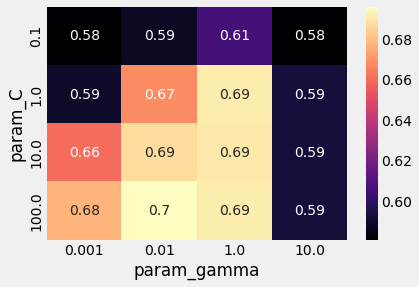

In [ ]:
test,validation,result,class_split,best_score = SVM_model(df_p,df_n)

In [ ]:
valid_df= pd.DataFrame(validation)
test_df=pd.DataFrame(test)
splits= pd.DataFrame(class_split)
score= pd.DataFrame(best_score)

In [ ]:
splits

,split_no,train_p,train_n,test_p,test_n
0,0,4027,5573,1016,1384


In [ ]:
valid_df

,Split,C,gamma,Sensitivity,Specificity,Accuracy,Recall,Precision,F1_score
0,0,100,0.01,0.66377,0.818949,0.753854,0.66377,0.725964,0.693475


In [ ]:
test_df

,Split,C,gamma,Sensitivity,Specificity,Accuracy,Recall,Precision,F1_score
0,0,100,0.01,0.600394,0.776734,0.702083,0.600394,0.663765,0.630491


0
Loading in word vectors...
Finished loading in word vectors
Numer of samples with no words found: 41 / 9600
Numer of samples with no words found: 15 / 2400


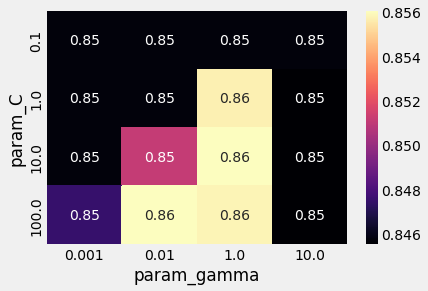

In [ ]:
df_p_t= df['text_lemmatized']
df_n_t= df['TR']
test_t,validation_t,result_t,class_split_t,best_score_t = SVM_model(df_p_t,df_n_t)

In [ ]:
targeted_validation=pd.DataFrame(validation_t)
targeted_test=pd.DataFrame(test_t)
targeted_class_split=pd.DataFrame(class_split_t)
targeted_best_score=pd.DataFrame(best_score_t)

In [ ]:
targeted_validation

,Split,C,gamma,Sensitivity,Specificity,Accuracy,Recall,Precision,F1_score
0,0,10,1,0.988521,0.999754,0.998021,0.988521,0.998636,0.993553


In [ ]:
targeted_test

,Split,C,gamma,Sensitivity,Specificity,Accuracy,Recall,Precision,F1_score
0,0,10,1,0.251928,0.963202,0.847917,0.251928,0.569767,0.349376


0
Loading in word vectors...
Finished loading in word vectors
Numer of samples with no words found: 41 / 9600
Numer of samples with no words found: 15 / 2400


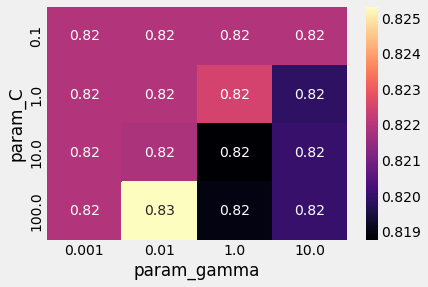

In [ ]:
df_p_a= df['text_lemmatized']
df_n_a= df['AG']
test_a,validation_a,result_a,class_split_a,best_score_a = SVM_model(df_p_a,df_n_a)

In [ ]:
aggressive_validation=pd.DataFrame(validation_a)
aggressive_test=pd.DataFrame(test_a)
aggressive_class_split=pd.DataFrame(class_split_a)
aggressive_best_score=pd.DataFrame(best_score_a)

In [ ]:
aggressive_validation

,Split,C,gamma,Sensitivity,Specificity,Accuracy,Recall,Precision,F1_score
0,0,100,0.01,0.059684,0.999366,0.832083,0.059684,0.953271,0.112335


In [ ]:
aggressive_test

,Split,C,gamma,Sensitivity,Specificity,Accuracy,Recall,Precision,F1_score
0,0,100,0.01,0.024775,0.998978,0.81875,0.024775,0.846154,0.04814


In [ ]:
!pip install xlsxwriter

In [ ]:
# writer = pd.ExcelWriter('GloVe_NLP_SVM.xlsx', engine='xlsxwriter')
# for i,data in enumerate(result):
#     data.to_excel(writer, sheet_name= 'Split_{}'.format(i),index=False)
# writer.save()

In [ ]:
# valid_df.to_excel('glove_svm_validation.xlsx',index=False)
# test_df.to_excel('glove_svm_test.xlsx',index=False)